# Loading & Splitting Data

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = load_boston()
X = boston.data # housing features
y = boston.target # housing prices

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Train & Test Split Only (yucky)

In [4]:
def my_rmse(y_true, y_pred):
    mse = ((y_true - y_pred)**2).mean()
    return np.sqrt(mse)

In [5]:
foo = np.array([4,3,1,6,8])
bar = np.array([4,6,1,3,7])
print(my_rmse(foo,bar))
print(np.sqrt(mean_squared_error(foo,bar)))

1.94935886896
1.94935886896


In [6]:
# Fit your model using the training set
linear = LinearRegression()
linear.fit(X_train, y_train)

# Call predict to get the predicted values for training and test set
train_predicted = linear.predict(X_train)
test_predicted = linear.predict(X_test)

# Calculate RMSE for training and test set
print('RMSE for training set ', my_rmse(y_train, train_predicted))
print('RMSE for test set ', my_rmse(y_test, test_predicted))

RMSE for training set  4.82624108057
RMSE for test set  4.51792883937


When we evaluate our RMSE on a new set of data, we gain an understanding of how well we are 
capturing the signal in our data.  We can build more complex models that may bend to perfectly
fit our training data.  However, these models are not going to extend well to a new set of data,
because they are likely overfit to our training data.  

By evaluating our performance metric on a new set of data, we assure that we are modeling signal
and not the noise in our data.


# K-Fold Cross Validation (woo yeah)

In [7]:
def my_cross_val_score(X_data, y_data, num_folds=3):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=num_folds)
    error = np.empty(num_folds)
    index = 0
    linear = LinearRegression()
    for train, test in kf.split(X_data):
        linear.fit(X_data[train], y_data[train])
        pred = linear.predict(X_data[test])
        error[index] = my_rmse(pred, y_data[test])
        index += 1
    return np.mean(error)

In [8]:
my_cross_val_score(X_train, y_train, num_folds=5)

5.2776622447824755

"do k-fold cross validation where you limit the training set size by varying amounts"

This could mean either changing k (higher k means there is more data in the training folds), or fixing k and restricting the amount of data we use in the first place.

Let's try the latter first:

In [9]:
cv_scores = []
for n in range(20,300):
    cv_score = my_cross_val_score(X_train[:n], y_train[:n], num_folds=5)
    cv_scores.append(cv_score)

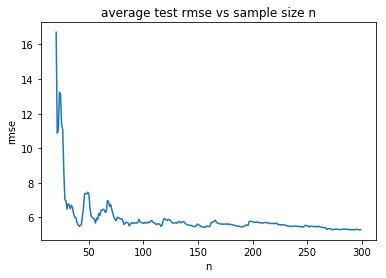

In [10]:
plt.plot(list(range(20,300)),cv_scores)
plt.xlabel('n')
plt.ylabel('rmse')
plt.title('average test rmse vs sample size n');

What if we use all the data and vary the number of folds?

In [11]:
cv_scores = []
for k in range(2,51):
    cv_score = my_cross_val_score(X_train, y_train, num_folds=k)
    cv_scores.append(cv_score)

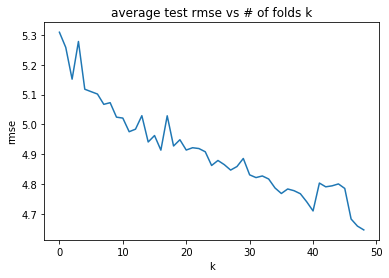

In [12]:
plt.plot(cv_scores)
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('average test rmse vs # of folds k');

I like to see train error along with test error, so let's modify that function a bit

In [13]:
def my_cross_val_scores(X_data, y_data, num_folds=3):
    ''' Returns error for k-fold cross validation. '''
    kf = KFold(n_splits=num_folds)
    train_error = np.empty(num_folds)
    test_error = np.empty(num_folds)
    index = 0
    linear = LinearRegression()
    for train, test in kf.split(X_data):
        linear.fit(X_data[train], y_data[train])
        pred_train = linear.predict(X_data[train])
        pred_test = linear.predict(X_data[test])
        train_error[index] = my_rmse(pred_train, y_data[train])
        test_error[index] = my_rmse(pred_test, y_data[test])
        index += 1
    return np.mean(test_error), np.mean(train_error)

Here's rmse vs sample size:

In [14]:
cv_test_scores = []
cv_train_scores = []

for n in range(20,301):
    cv_test, cv_train = my_cross_val_scores(X_train[:n], y_train[:n], num_folds=5)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

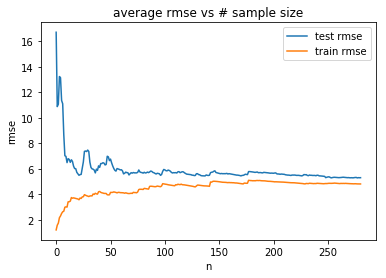

In [15]:
plt.plot(cv_test_scores, label='test rmse')
plt.plot(cv_train_scores, label='train rmse')
plt.xlabel('n')
plt.ylabel('rmse')
plt.title('average rmse vs # sample size')
plt.legend();

And vs # of folds:

In [16]:
cv_test_scores = []
cv_train_scores = []

for k in range(2,51):
    cv_test, cv_train = my_cross_val_scores(X_train, y_train, num_folds=k)
    cv_test_scores.append(cv_test)
    cv_train_scores.append(cv_train)

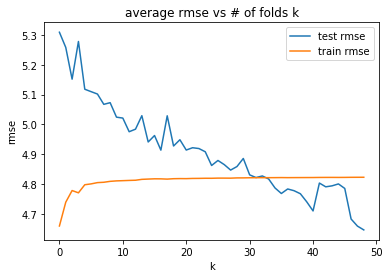

In [17]:
plt.plot(cv_test_scores, label='test rmse')
plt.plot(cv_train_scores, label='train rmse')
plt.xlabel('k')
plt.ylabel('rmse')
plt.title('average rmse vs # of folds k')
plt.legend();

# Stepwise Regression (extra credit)

In [18]:
from sklearn.datasets import make_friedman1

In [19]:
X_fri, y_fri = make_friedman1(n_samples=5000, n_features=100, random_state=0)

In [20]:
from sklearn.feature_selection import RFE

In [21]:
n_samples = X_fri.shape[0]
n_features = X_fri.shape[1]
r2_scores = np.zeros(n_features)
adj_r2_scores = np.zeros(n_features)

for p in range(1,n_features+1):
    rfe = RFE(LinearRegression(), n_features_to_select=p)
    rfe.fit(X_fri, y_fri)
    r2 = rfe.score(X_fri, y_fri)
    adj_r2 = 1 - ((1 - r2)*(n_samples - 1)/(n_samples - p - 1))
    r2_scores[p-1] = r2
    adj_r2_scores[p-1] = adj_r2

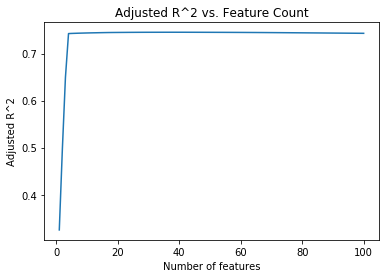

In [22]:
plt.plot(np.arange(1,n_features +1), adj_r2_scores)
plt.title('Adjusted R^2 vs. Feature Count')
plt.xlabel('Number of features')
plt.ylabel('Adjusted R^2');

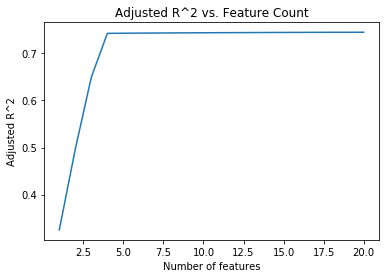

In [23]:
plt.plot(np.arange(1,n_features +1)[:20], adj_r2_scores[:20])
plt.title('Adjusted R^2 vs. Feature Count')
plt.xlabel('Number of features')
plt.ylabel('Adjusted R^2');

## Forward Selection

In [24]:
import statsmodels.api as sm

/home/moses/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
class ForwardSelect(object):
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.best_score = 0.
        self.column_names = []
        self.keep = []
        self.X_orig = None
        self.X = None
        self.y = None

    def fit_transform(self, df, target):
        self.y = target
        self.column_names = df.columns.tolist()
        self.X_orig = df.values
        self.X = np.ones([self.X_orig.shape[0],1])
        
        while self.X_orig.shape[1] > 0:
            scores = []
            for feature in range(self.X_orig.shape[1]):
                X_temp = np.concatenate((self.X, self.X_orig[:, feature, None]), axis=1)
                scores.append(sm.OLS(self.y, X_temp).fit().rsquared_adj)
            best_idx = np.argmax(np.asanyarray(scores))

            if scores[best_idx] <= self.best_score:
                if self.verbose: 
                    print('Removed columns ->', self.column_names)
                    print('-> All done!')
                return self.X[:,1:]
            else:
                self.X = np.concatenate((self.X, self.X_orig[:, best_idx, None]), axis=1)
                self.X_orig = np.delete(self.X_orig, best_idx, axis=1)
                self.keep.append(self.column_names.pop(best_idx))
                self.best_score = scores[best_idx]
                if self.verbose: print('Kept \'%s\' for a best score of %s' % (self.keep[-1], self.best_score))

In [26]:
df = pd.DataFrame(X_fri)
forward = ForwardSelect(verbose=True)
forward.fit_transform(df, y_fri)

Kept '3' for a best score of 0.325044526177
Kept '1' for a best score of 0.496862089347
Kept '0' for a best score of 0.649410069763
Kept '4' for a best score of 0.742511445509
Kept '85' for a best score of 0.742826732836
Kept '63' for a best score of 0.743051990062
Kept '62' for a best score of 0.743275184203
Kept '31' for a best score of 0.743469707371
Kept '83' for a best score of 0.743650242228
Kept '61' for a best score of 0.743822492933
Kept '50' for a best score of 0.743982268044
Kept '76' for a best score of 0.744118206892
Kept '34' for a best score of 0.744252359139
Kept '10' for a best score of 0.744391144585
Kept '49' for a best score of 0.744518211164
Kept '75' for a best score of 0.744628198383
Kept '53' for a best score of 0.744727858234
Kept '60' for a best score of 0.744801786633
Kept '67' for a best score of 0.744869278354
Kept '14' for a best score of 0.744925507577
Kept '84' for a best score of 0.744974576011
Kept '71' for a best score of 0.745020657501
Kept '6' for a

array([[ 0.54488318,  0.71518937,  0.5488135 , ...,  0.891773  ,
         0.26455561,  0.19658236],
       [ 0.96218855,  0.27000797,  0.67781654, ...,  0.57225191,
         0.61801543,  0.97552151],
       [ 0.17960368,  0.69634349,  0.31179588, ...,  0.45369684,
         0.25394164,  0.66991655],
       ..., 
       [ 0.42765067,  0.80651368,  0.71095129, ...,  0.09874679,
         0.28336513,  0.78268399],
       [ 0.68665604,  0.90201405,  0.56393894, ...,  0.40972928,
         0.52512261,  0.22717661],
       [ 0.71913573,  0.8473786 ,  0.57768068, ...,  0.27530496,
         0.89432694,  0.93860404]])

Let's try it on the Boston data set

In [27]:
boston = load_boston()
X = boston.data # Attribute data
y = boston.target # Housing prices
colNames = boston.feature_names # Feature names


In [28]:
df_bos = pd.DataFrame(X, columns=colNames)
forward = ForwardSelect(verbose=True)
forward.fit_transform(df_bos, y)


Kept 'LSTAT' for a best score of 0.543241825955
Kept 'RM' for a best score of 0.63712447547
Kept 'PTRATIO' for a best score of 0.676703587413
Kept 'DIS' for a best score of 0.687835108484
Kept 'NOX' for a best score of 0.705170182246
Kept 'CHAS' for a best score of 0.712356667191
Kept 'B' for a best score of 0.718256040716
Kept 'ZN' for a best score of 0.722207180409
Kept 'CRIM' for a best score of 0.723897942526
Kept 'RAD' for a best score of 0.728783937621
Kept 'TAX' for a best score of 0.734768021829
Removed columns -> ['INDUS', 'AGE']
-> All done!


array([[  4.98000000e+00,   6.57500000e+00,   1.53000000e+01, ...,
          6.32000000e-03,   1.00000000e+00,   2.96000000e+02],
       [  9.14000000e+00,   6.42100000e+00,   1.78000000e+01, ...,
          2.73100000e-02,   2.00000000e+00,   2.42000000e+02],
       [  4.03000000e+00,   7.18500000e+00,   1.78000000e+01, ...,
          2.72900000e-02,   2.00000000e+00,   2.42000000e+02],
       ..., 
       [  5.64000000e+00,   6.97600000e+00,   2.10000000e+01, ...,
          6.07600000e-02,   1.00000000e+00,   2.73000000e+02],
       [  6.48000000e+00,   6.79400000e+00,   2.10000000e+01, ...,
          1.09590000e-01,   1.00000000e+00,   2.73000000e+02],
       [  7.88000000e+00,   6.03000000e+00,   2.10000000e+01, ...,
          4.74100000e-02,   1.00000000e+00,   2.73000000e+02]])